<a href="https://colab.research.google.com/github/kunjkinger/machine-learning-projects/blob/graphical_modelling/Claim_graphical_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.approximation import clique



In [20]:
!pip install pymcmcstat
!pip install pgmpy

     |████████████████████████████████| 337kB 3.9MB/s 


In [2]:

df = pd.read_csv('Claim_Dataset_Part1.csv')
df.head()
df.describe()
df.info()


df['Total_Supply'] = df['Days'] * df['Qty']
df['claim amount'] = df['Total_Supply'] * df['Amount']

df.reset_index(drop=True,inplace=True)
X = df[['UID','PhID','CLID','PATID','PresID','DCID','Strength','Refill','Qty','Amount','Total_Supply','claim amount']]
y = df.iloc[:,19]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   UID           2000 non-null   int64  
 1   PhID          2000 non-null   int64  
 2   PresID        2000 non-null   int64  
 3   CLID          2000 non-null   float64
 4   PATID         2000 non-null   int64  
 5   ID            2000 non-null   int64  
 6   DCID          2000 non-null   int64  
 7   Qty           2000 non-null   int64  
 8   Days          2000 non-null   int64  
 9   Refill        2000 non-null   int64  
 10  Strength      2000 non-null   float64
 11  Amount        2000 non-null   float64
 12  Gender        2000 non-null   int64  
 13  Age           2000 non-null   int64  
 14  Fill Date     2000 non-null   object 
 15  Written Date  2000 non-null   object 
 16  Fill GAP      2000 non-null   int64  
 17  NextRefill    2000 non-null   object 
 18  EarlyRefill   2000 non-null 

In [3]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [5]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)


In [6]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
print(confusion_matrix(y_test,y_pred))
accuracy_score(y_test,y_pred)
print(classification_report(y_test,y_pred))


[[589   0]
 [ 11   0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       589
           1       0.00      0.00      0.00        11

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.50       600
weighted avg       0.96      0.98      0.97       600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 1.70196762, -0.96032194, -0.17140744,  0.78165186, -0.01192656,
         0.21529771,  1.5649512 , -0.52674028,  2.90298097, -0.15561694,
        -1.94350416, -0.39285909]])

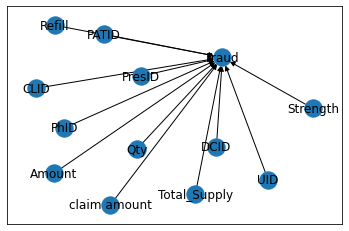

In [7]:
sample_id = 12
x_test_sample = x_test[sample_id,:].reshape(1,-1)

lr.predict(x_test_sample.reshape(1,-1))


#bayesian networks
g = nx.DiGraph()
g.add_edges_from([('UID','Fraud'),('PhID','Fraud'),('CLID','Fraud'),('PATID','Fraud'),('PresID','Fraud'),('DCID','Fraud'),('Strength','Fraud'),('Refill','Fraud'),('Qty','Fraud'),('Amount','Fraud'),('Total_Supply','Fraud'),('claim amount','Fraud')])
nx.draw_networkx(g)

lr.predict_proba(x_test_sample)
lr.coef_


In [8]:
score = np.dot(lr.coef_,x_test_sample[0])


In [9]:
score

array([0.99611511])

In [10]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

sigmoid(score)


array([0.73029408])

In [11]:
#adding intercept in the score
sigmoid(lr.intercept_ + score)


array([0.02934033])

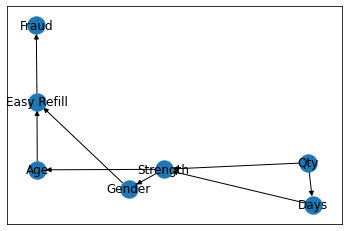

In [12]:
# bayesian networks part 2
b = nx.DiGraph()
b.add_edges_from([('Qty','Days'),('Qty','Strength'),('Days','Strength'),('Strength','Gender'),('Strength','Age'),('Gender','Easy Refill'),('Age','Easy Refill'),('Easy Refill','Fraud')])
nx.draw_networkx(b)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


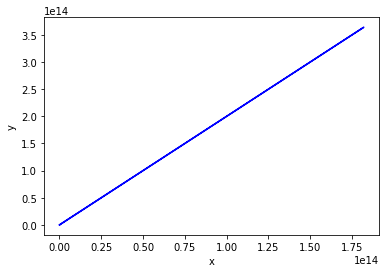

In [15]:
def model(data,q):
    m,b = q # slope and offset
    x = data.xdata[0]
    return m*x + b

from pymcmcstat.MCMC import DataStructure
data = DataStructure()
data.add_data_set(X,y)
qtrue = [2.0, 3.0]
x = data.xdata[0]
sigma=[0.1]
y= model(data,qtrue) + sigma*np.random.standard_normal(x.shape)
fig = plt.figure()
ax = fig.gca()
tmp = ax.plot(x,y,'b')
ax.set_xlabel('x')
ax.set_ylabel('y');


In [16]:
#sse function
def ssfun(q, data):
    #extract y data
    ydata = data.ydata[0]
    #evaluate model
    ymodel = model(data,q)
    res = ymodel.reshape(ydata.shape) - ydata
    return (res**2).sum(axis=0)


In [17]:
from pymcmcstat.MCMC import MCMC
mcstat = MCMC()
mcstat.data.add_data_set(X,y)#add data
mcstat.model_settings.define_model_settings(sos_function=ssfun) # assign cost function
mcstat.simulation_options.define_simulation_options(nsimu=10.0e3,updatesigma=True)


In [18]:
from pymcmcstat.MCMC import MCMC
mcstat = MCMC()
mcstat.data.add_data_set(X,y)#add data
mcstat.model_settings.define_model_settings(sos_function=ssfun) # assign cost function
mcstat.simulation_options.define_simulation_options(nsimu=10.0e3,updatesigma=True)

#add model parameters
mcstat.parameters.add_model_parameter(name='m',theta0=1.5)
mcstat.parameters.add_model_parameter(name='b',theta0=2.75,minimum=-5,maximum=5)

mcstat.run_simulation()



Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         m:      1.50 [     -inf,       inf] N( 0.00e+00,      inf)
         b:      2.75 [    -5.00,      5.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 10000 of 10000 complete in 8.3 sec

In [21]:

from pgmpy.models import BayesianModel
model = BayesianModel([('UID','Fraud'),('PhID','Fraud'),('CLID','Fraud'),
                       ('PATID','Fraud'),('PresID','Fraud'),('DCID','Fraud'),
                       ('Strength','Fraud'),('Refill','Fraud'),('Qty','Fraud'),
                       ('Amount','Fraud'),('Total_Supply','Fraud'),('claim amount','Fraud'),
                       ('Days','Fraud'),('Gender','Fraud'),('Fill Date','Fraud'),
                       ('Written Date','Fraud'),('Fill GAP','Fraud'),('NextRefill','Fraud'),
                       ('EarlyRefill','Fraud'),('ID','Fraud'),('Age','Fraud')])


In [22]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model,df)
print("\n",pe.state_counts('UID'))
print("\n",pe.state_counts('PhID'))
print("\n",pe.state_counts('PresID'))
print("\n",pe.state_counts('CLID'))
print("\n",pe.state_counts('PATID'))
print("\n",pe.state_counts('ID'))
print("\n",pe.state_counts('DCID'))
print("\n",pe.state_counts('Strength'))
print("\n",pe.state_counts('Refill'))
print("\n",pe.state_counts('Qty'))
print("\n",pe.state_counts('Gender'))
print("\n",pe.state_counts('Days'))
print("\n",pe.state_counts('Amount'))
print("\n",pe.state_counts('Fill Date'))
print("\n",pe.state_counts('Written Date'))
print("\n",pe.state_counts('Fill GAP'))
print("\n",pe.state_counts('NextRefill'))
print("\n",pe.state_counts('EarlyRefill'))
print("\n",pe.state_counts('Age'))
print("\n",pe.state_counts('Total_Supply'))
print("\n",pe.state_counts('claim amount'))



       UID
1       1
2       1
3       1
4       1
5       1
...   ...
1996    1
1997    1
1998    1
1999    1
2000    1

[2000 rows x 1 columns]

          PhID
722476      1
1011480     1
3100204     1
3100926     5
3101521    70
...       ...
3199300    50
3199555     2
3199579     3
3199832    10
3199920     2

[242 rows x 1 columns]

            PresID
2472            1
6589            1
6720            1
7436            1
9516            1
...           ...
17301820        1
17333063        1
57497396        1
950248758       1
960120039       1

[1944 rows x 1 columns]

               CLID
1.630000e+14    77
1.640000e+14    75
1.700000e+14   155
1.710000e+14   375
1.720000e+14   378
1.730000e+14   389
1.740000e+14    47
1.800000e+14   102
1.810000e+14   281
1.820000e+14   121

         PATID
200599      1
200810      3
201658      3
201666      2
201781      1
...       ...
263432      1
263627      2
263643      1
263655      1
263829      3

[334 rows x 1 columns]

          

In [23]:
#maximum likelihood estimator
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, df)
print(mle.estimate_cpd('UID'))
print("\n",mle.estimate_cpd('PhID'))
print("\n",mle.estimate_cpd('PresID'))
print("\n",mle.estimate_cpd('CLID'))
print("\n",mle.estimate_cpd('PATID'))
print("\n",mle.estimate_cpd('ID'))
print("\n",mle.estimate_cpd('DCID'))
print("\n",mle.estimate_cpd('Strength'))
print("\n",mle.estimate_cpd('Refill'))
print("\n",mle.estimate_cpd('Qty'))
print("\n",mle.estimate_cpd('Gender'))
print("\n",mle.estimate_cpd('Days'))
print("\n",mle.estimate_cpd('Amount'))
print("\n",mle.estimate_cpd('Fill Date'))
print("\n",mle.estimate_cpd('Written Date'))
print("\n",mle.estimate_cpd('Fill GAP'))
print("\n",mle.estimate_cpd('NextRefill'))
print("\n",mle.estimate_cpd('EarlyRefill'))
print("\n",mle.estimate_cpd('Age'))
print("\n",mle.estimate_cpd('Total_Supply'))
print("\n",mle.estimate_cpd('claim amount'))


Streaming output truncated to the last 5000 lines.
| Amount(49.0)    | 0.006  |
+-----------------+--------+
| Amount(49.75)   | 0.002  |
+-----------------+--------+
| Amount(51.13)   | 0.0005 |
+-----------------+--------+
| Amount(51.25)   | 0.0025 |
+-----------------+--------+
| Amount(52.15)   | 0.0065 |
+-----------------+--------+
| Amount(52.75)   | 0.0045 |
+-----------------+--------+
| Amount(52.96)   | 0.0085 |
+-----------------+--------+
| Amount(53.41)   | 0.0005 |
+-----------------+--------+
| Amount(57.55)   | 0.0065 |
+-----------------+--------+
| Amount(58.75)   | 0.007  |
+-----------------+--------+
| Amount(60.55)   | 0.003  |
+-----------------+--------+
| Amount(64.75)   | 0.0075 |
+-----------------+--------+
| Amount(67.75)   | 0.008  |
+-----------------+--------+
| Amount(70.0)    | 0.0005 |
+-----------------+--------+
| Amount(70.03)   | 0.0195 |
+-----------------+--------+
| Amount(78.75)   | 0.0005 |
+-----------------+--------+
| Amount(85.75)   | 0

In [24]:
model2 = BayesianModel([('Qty','Days'),('Qty','Strength'),('Days','Strength'),('Strength','Gender'),('Strength','Age'),('Age','EarlyRefill'),('EarlyRefill','Fraud')])


In [25]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model2,df)

print(est.estimate_cpd('Fraud'))

#Markov 1
model2 = BayesianModel([('Total_Supply','Strength'),('Days','Strength')])

#markov process
state = df['Strength'].unique().tolist()
state

##extracting patient id
pat_list = df['PATID'].unique().tolist()


+-------------+-----------------------+---------------------+
| EarlyRefill | EarlyRefill(0)        | EarlyRefill(1)      |
+-------------+-----------------------+---------------------+
| Fraud(0)    | 0.9963628583654257    | 0.93753735803945    |
+-------------+-----------------------+---------------------+
| Fraud(1)    | 0.0036371416345742404 | 0.06246264196054991 |
+-------------+-----------------------+---------------------+


In [26]:
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

cpd_Total_Supply = TabularCPD('Total_Supply',2,[[0.7],[0.3]])
cpd_Days =  TabularCPD('Days',2,[[0.8],[0.2]])
cpd_Strength = TabularCPD('Strength',2,[[0.8,0.3,0.7,0.1],
                                        [0.2,0.7,0.3,0.9]],['Total_Supply','Days'],[2,2])


In [27]:

model2.add_cpds(cpd_Total_Supply,cpd_Days,cpd_Strength)
print(cpd_Total_Supply)
print(cpd_Days)
print(cpd_Strength)


+-----------------+-----+
| Total_Supply(0) | 0.7 |
+-----------------+-----+
| Total_Supply(1) | 0.3 |
+-----------------+-----+
+---------+-----+
| Days(0) | 0.8 |
+---------+-----+
| Days(1) | 0.2 |
+---------+-----+
+--------------+-----------------+-----------------+-----------------+-----------------+
| Total_Supply | Total_Supply(0) | Total_Supply(0) | Total_Supply(1) | Total_Supply(1) |
+--------------+-----------------+-----------------+-----------------+-----------------+
| Days         | Days(0)         | Days(1)         | Days(0)         | Days(1)         |
+--------------+-----------------+-----------------+-----------------+-----------------+
| Strength(0)  | 0.8             | 0.3             | 0.7             | 0.1             |
+--------------+-----------------+-----------------+-----------------+-----------------+
| Strength(1)  | 0.2             | 0.7             | 0.3             | 0.9             |
+--------------+-----------------+-----------------+----------------

In [28]:
model_inference = VariableElimination(model2)
print(model_inference.map_query(variables=['Strength'],evidence={'Total_Supply':1,'Days':0}))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

{'Strength': 0}
